# Target of notebook
- create black box model for time series
- test model with all the collected data set

# Package

In [83]:
from __future__ import annotations

import logging 
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from dataclasses import dataclass
from pathlib import Path
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.io import arff
from skimage import io
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import cast, Any, Dict, List, Tuple, Optional


In [2]:
torch.manual_seed(1)

# Plot Functions

In [50]:
def plot_line_in_df(df, ids, y_range = None, save_path = None, id = None):
    """
    drop linear plot for columns A and B in dataframe df.
    parameter:
    =============
    df, type of DataFrame
        - target data frame
    step, type of int
        - plot the value every ||step|| items
    cols, multi parameter
        - each steht for a columns that needs to plot in the figure
    """
    for i in ids:
        plt.figure(figsize=(20,6))
        df = df.reset_index(drop = True)
        if y_range:
            plt.ylim(y_range[0], y_range[1])
        else:
            plt.ylim(-.5,.5)
        plt.plot(df.iloc[i,:-1].values)
        plt.xlabel('Index')
        #plt.legend()
        plt.title(df.iloc[i,-1])
        plt.tick_params(axis='x',labelsize=18)
        plt.tick_params(axis='y',labelsize=18)
    #plt.legend(prop={'size': 16})
    if save_path:
        save_path = save_path+'_step_'+str(step)
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        plt.savefig(save_path+ '/' +'_'.join(cols)+ '_' + str(id), transparent = True)



# Load data and plot
- AbnormalHeartbeat_TRAIN数据有些奇怪，相同类的不同数据相差太大，几乎看不出区别
- BinaryHeartbeat_TRAIN每个记录都有万多个数据

## plot

In [185]:
data = arff.loadarff('../data/AbnormalHeartbeat/AbnormalHeartbeat_TRAIN.arff')
df = pd.DataFrame(data[0])

In [186]:
df.iloc[:,-1].value_counts()

b'Normal'        175
b'Murmur'         64
b'ExtraStole'     23
b'ExtraHLS'       20
b'Artifact'       20
Name: target, dtype: int64

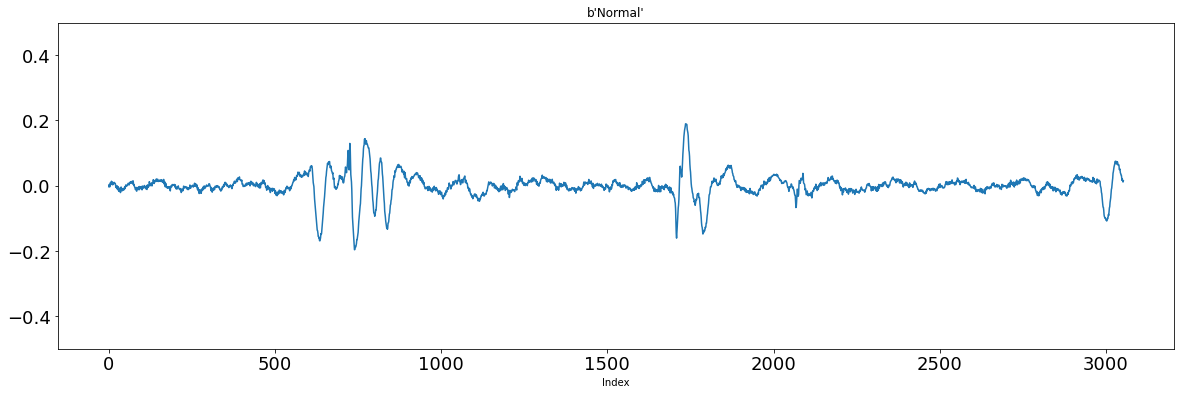

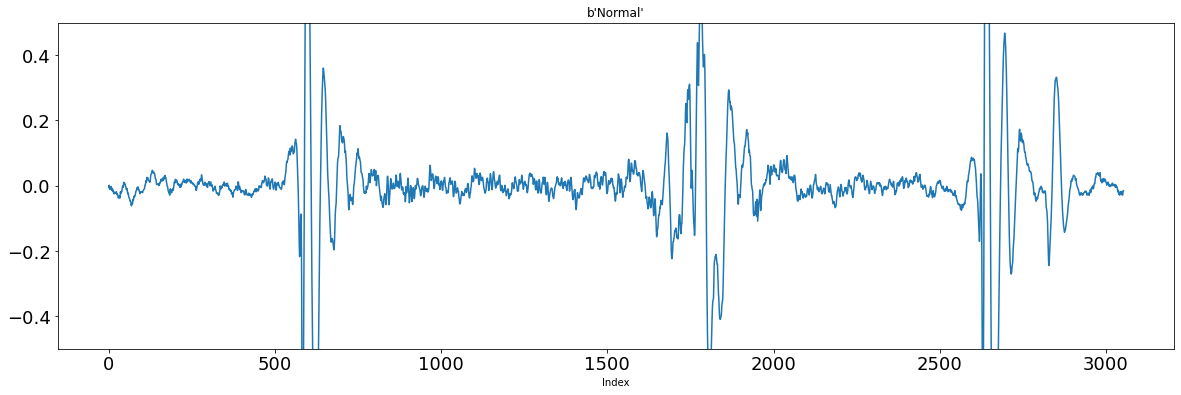

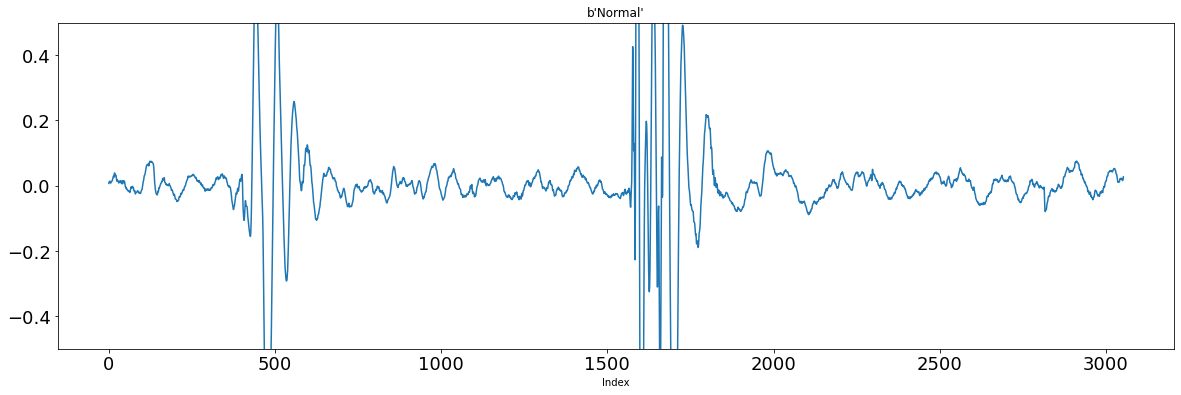

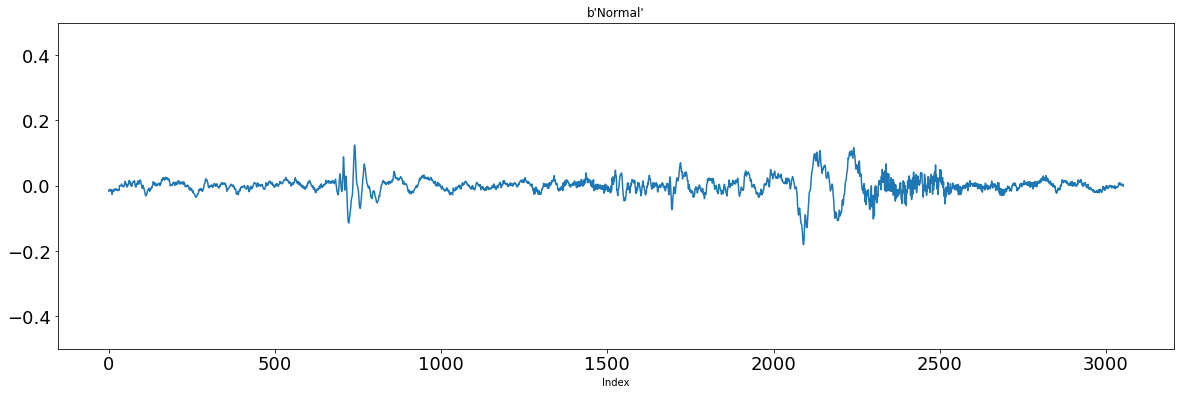

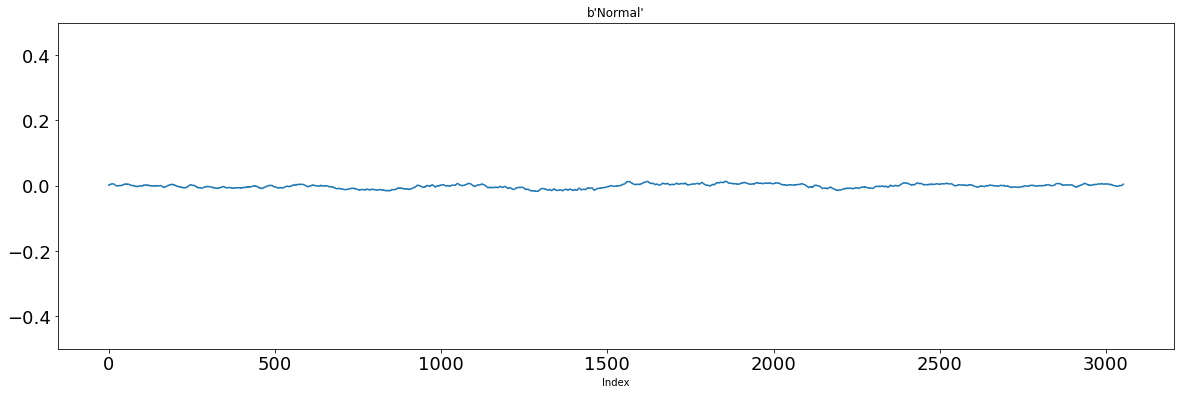

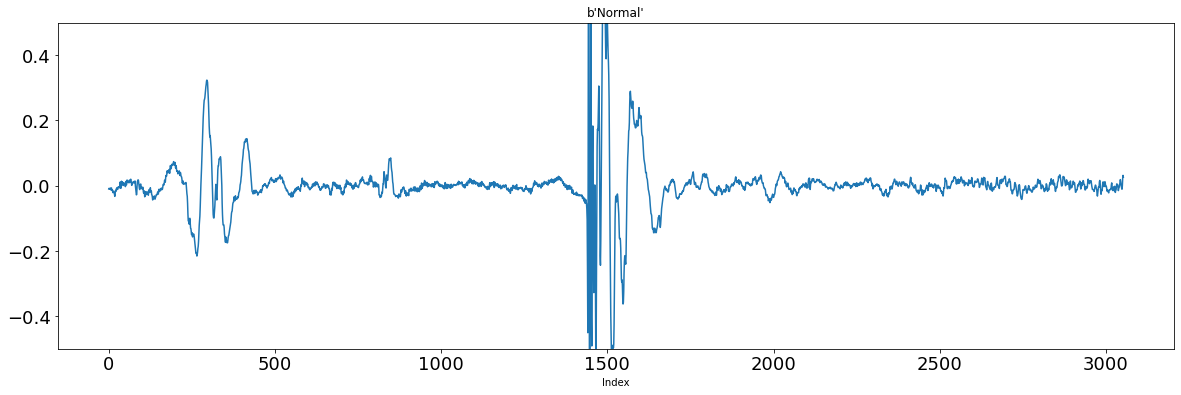

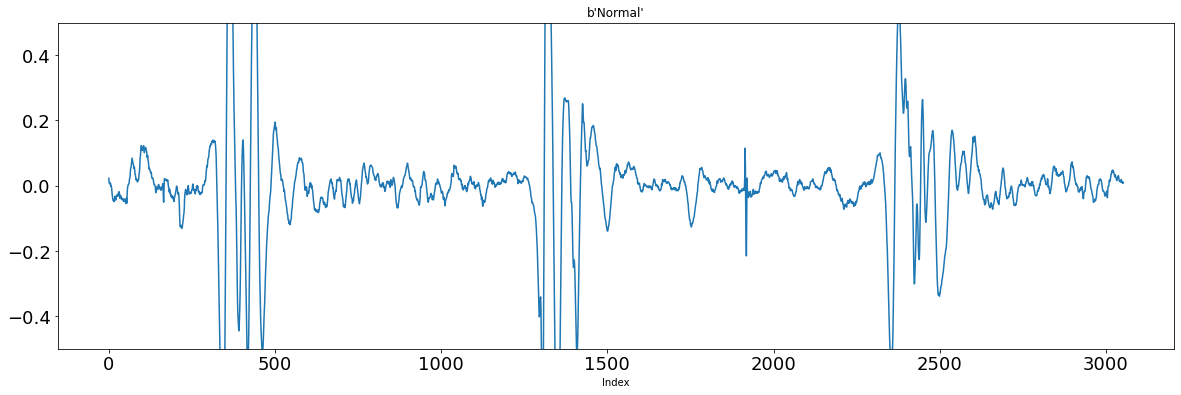

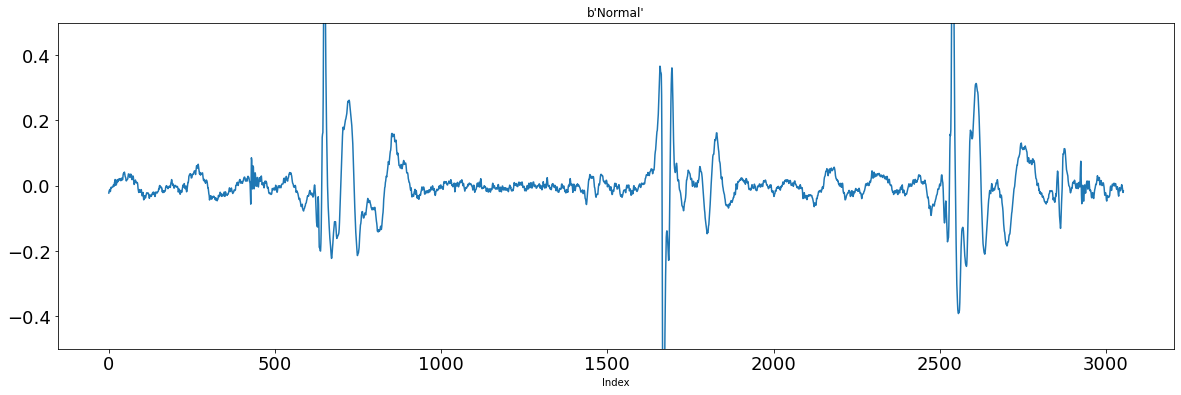

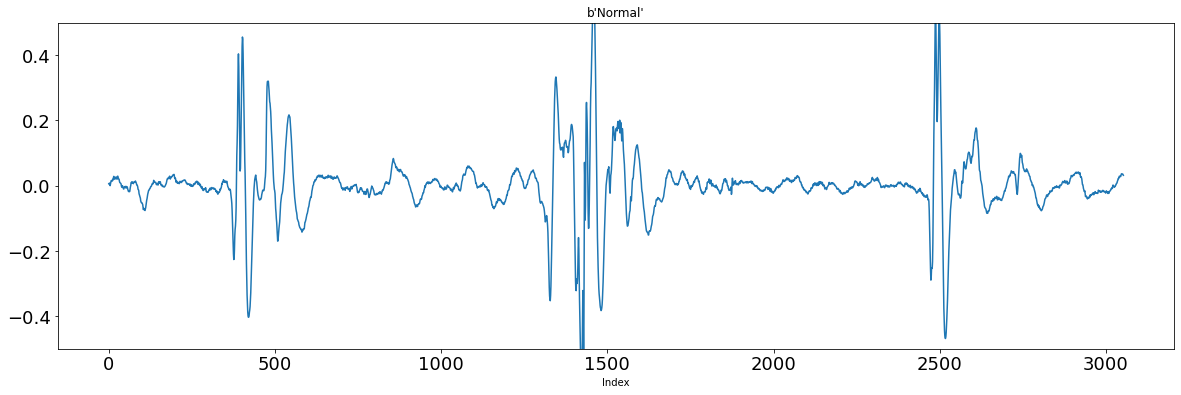

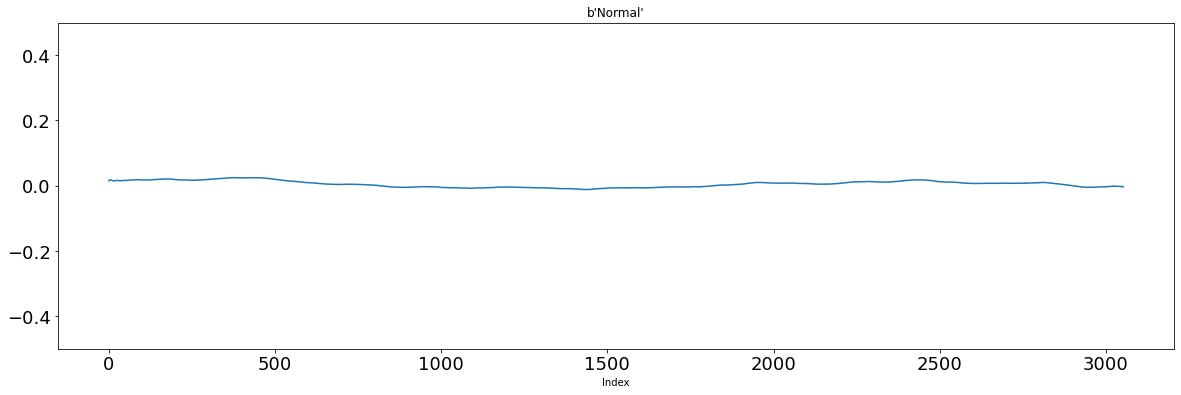

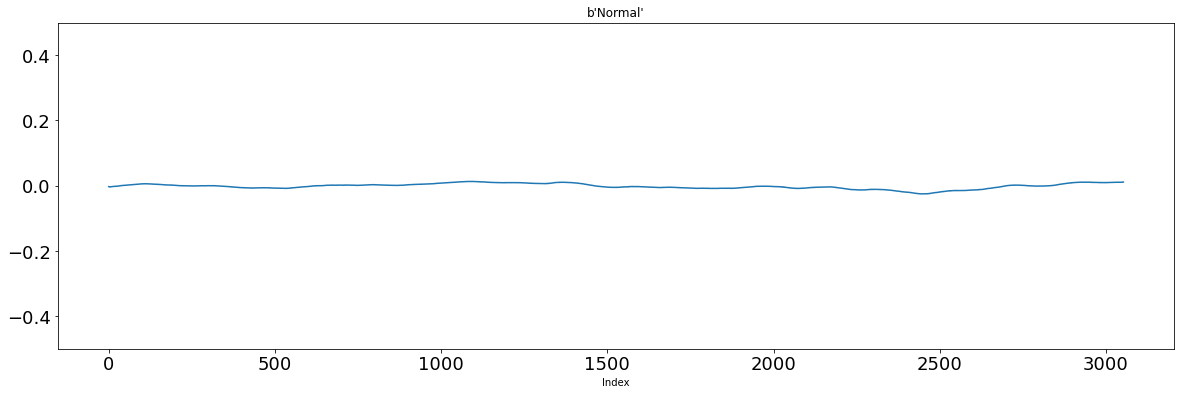

In [187]:
plot_line_in_df(df, range(144,155))

In [188]:
# target label encoding
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])

In [189]:
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

## Wrapping

In [190]:
batch_size = 60

In [201]:
class TSDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = torch.from_numpy(x).unsqueeze(1).float()
        onehot = OneHotEncoder(categories='auto', sparse=False)
        self.y = onehot.fit_transform(y.reshape(-1, 1))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [202]:
# train-val-test split
x_train, x_test, y_train, y_test\
    = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val \
    = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [203]:
# Data set & data loader
train_set = TSDataset(x_train, y_train)
val_set = TSDataset(x_val, y_val)
test_set = TSDataset(x_test, y_test)
train_loader = DataLoader(train_set,batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

# Models

## Trainer design

In [175]:
class BaseTrainer:
    """Trains an inception model. Dataset-specific trainers should extend this class
    and implement __init__, get_loaders and save functions.
    See UCRTrainer in .ucr.py for an example.
    Attributes
    ----------
    The following need to be added by the initializer:
    model:
        The initialized inception model
    data_folder:
        A path to the data folder - get_loaders should look here for the data
    model_dir:
        A path to where the model and its predictions should be saved
    The following don't:
    train_loss:
        The fit function fills this list in as the model trains. Useful for plotting
    val_loss:
        The fit function fills this list in as the model trains. Useful for plotting
    test_results:
        The evaluate function fills this in, evaluating the model on the test data
    """
    model: nn.Module
    data_folder: Path
    model_dir: Path
    train_loss: List[float] = []
    val_loss: List[float] = []
    test_results: Dict[str, float] = {}
    input_args: Dict[str, Any] = {}

    def fit(self, train_loader, val_loader = None, num_epochs: int = 100,
            val_size: float = 0.2, learning_rate: float = 0.01,
            patience: int = 10) -> None:
        """Trains the inception model
        Arguments
        ----------
        batch_size:
            Batch size to use for training and validation
        num_epochs:
            Maximum number of epochs to train for
        val_size:
            Fraction of training set to use for validation
        learning_rate:
            Learning rate to use with Adam optimizer
        patience:
            Maximum number of epochs to wait without improvement before
            early stopping
        """
        if type(val_loader) == None:
            val_loader = train_loader
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        best_val_loss = np.inf
        patience_counter = 0
        best_state_dict = None

        for epoch in range(num_epochs):
            epoch_train_loss = []
            self.model.train()
            for x_t, y_t in train_loader: # train_epoch
                optimizer.zero_grad()
                output = self.model(x_t)
                if len(y_t.shape) == 1: # binary classification
                    train_loss = F.binary_cross_entropy_with_logits(
                        output, y_t.unsqueeze(-1).float(), reduction='mean'
                    )
                else: # multi class classification
                    train_loss = F.cross_entropy(output, y_t.argmax(dim=-1), reduction='mean')

                epoch_train_loss.append(train_loss.item())
                train_loss.backward()
                optimizer.step()
            self.train_loss.append(np.mean(epoch_train_loss))

            epoch_val_loss = []
            self.model.eval()
            for x_v, y_v in cast(DataLoader, val_loader): # val_epoch
                with torch.no_grad():
                    output = self.model(x_v)
                    if len(y_v.shape) == 1:
                        val_loss = F.binary_cross_entropy_with_logits(
                            output, y_v.unsqueeze(-1).float(), reduction='mean'
                        ).item()
                    else:
                        val_loss = F.cross_entropy(output,
                                                   y_v.argmax(dim=-1), reduction='mean').item()
                    epoch_val_loss.append(val_loss)
            self.val_loss.append(np.mean(epoch_val_loss))

            print(f'Epoch: {epoch + 1}, '
                  f'Train loss: {round(self.train_loss[-1], 3)}, '
                  f'Val loss: {round(self.val_loss[-1], 3)}')

            if self.val_loss[-1] < best_val_loss: # record best result and early stopping
                best_val_loss = self.val_loss[-1]
                best_state_dict = self.model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

                if patience_counter == patience:
                    if best_state_dict is not None:
                        self.model.load_state_dict(cast(Dict[str, torch.Tensor], best_state_dict))
                    print('Early stopping!')
                    return None

    def evaluate(self, test_loader) -> None:
        self.model.eval()
        true_list, preds_list = [], []
        for x, y in test_loader:
            with torch.no_grad():
                true_list.append(y.detach().numpy())
                preds = self.model(x)
                if len(y.shape) == 1:
                    preds = torch.sigmoid(preds)
                else:
                    preds = torch.softmax(preds, dim=-1)
                preds_list.append(preds.detach().numpy())

        true_np, preds_np = np.concatenate(true_list), np.concatenate(preds_list)

        self.test_results['roc_auc_score'] = roc_auc_score(true_np, preds_np)
        print(f'ROC AUC score: {round(self.test_results["roc_auc_score"], 3)}')

        self.test_results['accuracy_score'] = accuracy_score(
            *self._to_1d_binary(true_np, preds_np)
        )
        print(f'Accuracy score: {round(self.test_results["accuracy_score"], 3)}')

    @staticmethod
    def _to_1d_binary(y_true: np.ndarray, y_preds: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if len(y_true.shape) > 1:
            return np.argmax(y_true, axis=-1), np.argmax(y_preds, axis=-1)

        else:
            return y_true, (y_preds > 0.5).astype(int)

    def save_model(self, savepath: Optional[Path] = None) -> Path:
        raise NotImplementedError

In [176]:
class TSTrainer(BaseTrainer):
    """Train the model on UCR datasets
    Attributes
    ----------
    model:
        The initialized inception model
    experiment:
        The UCR/UEA dataset to train the model on
    data_folder:
        The location of the data_folder
    """

    def __init__(self, model: nn.Module):
        self.model = model

        # to be filled by the fit function
        self.train_loss: List[float] = []
        self.val_loss: List[float] = []
        self.test_results: Dict[str, float] = {}

    def save_model(self, savepath: Optional[Path] = None) -> Path:
        save_dict = {
            'model': {
                'model_class': self.model.__class__.__name__,
                'state_dict': self.model.state_dict(),
                'input_args': self.model.input_args,
            },
            'encoder': self.encoder
        }
        if savepath is None:
            model_name = f'{self.model.__class__.__name__}_model.pkl'
            savepath = '.' / model_name
        torch.save(save_dict, savepath)

        return savepath

## Models design

### Inception

In [212]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])
    #print(f'dilation: {dilation}, padding: {padding}, bias({type(bias)}): {bias}')
    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)


class ConvBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 stride: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        return self.layers(x)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

### Resnet

In [178]:
class ResNetBaseline(nn.Module):
    """A PyTorch implementation of the ResNet Baseline
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    sequence_length:
        The size of the input sequence
    mid_channels:
        The 3 residual blocks will have as output channels:
        [mid_channels, mid_channels * 2, mid_channels * 2]
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, in_channels: int, mid_channels: int = 64,
                 num_pred_classes: int = 1) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'in_channels': in_channels,
            'num_pred_classes': num_pred_classes
        }

        self.layers = nn.Sequential(*[
            ResNetBlock(in_channels=in_channels, out_channels=mid_channels),
            ResNetBlock(in_channels=mid_channels, out_channels=mid_channels * 2),
            ResNetBlock(in_channels=mid_channels * 2, out_channels=mid_channels * 2),

        ])
        self.final = nn.Linear(mid_channels * 2, num_pred_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.layers(x)
        return self.final(x.mean(dim=-1))


class ResNetBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        channels = [in_channels, out_channels, out_channels, out_channels]
        kernel_sizes = [8, 5, 3]

        self.layers = nn.Sequential(*[
            ConvBlock(in_channels=channels[i], out_channels=channels[i + 1],
                      kernel_size=kernel_sizes[i], stride=1) for i in range(len(kernel_sizes))
        ])

        self.match_channels = False
        if in_channels != out_channels:
            self.match_channels = True
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=1),
                nn.BatchNorm1d(num_features=out_channels)
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore

        if self.match_channels:
            return self.layers(x) + self.residual(x)
        return self.layers(x)

### Convolutiona network

In [179]:
class FCNBaseline(nn.Module):
    """A PyTorch implementation of the FCN Baseline
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    sequence_length:
        The size of the input sequence
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, in_channels: int, num_pred_classes: int = 1) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'in_channels': in_channels,
            'num_pred_classes': num_pred_classes
        }

        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 128, 8, 1),
            ConvBlock(128, 256, 5, 1),
            ConvBlock(256, 128, 3, 1),
        ])
        self.final = nn.Linear(128, num_pred_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.layers(x)
        return self.final(x.mean(dim=-1))

## Init, train and evaluate model

In [227]:
# model: [batch_size, in_channel, seq_len] ==> 
model = InceptionModel(num_blocks=8, in_channels=1, out_channels=8,
                           bottleneck_channels=2, kernel_sizes=4, use_residuals=True,#
                           num_pred_classes=5)
#model = ResNetBaseline(in_channels=1, num_pred_classes=5)
#model = FCNBaseline(in_channels=1, num_pred_classes=5)
trainer = TSTrainer(model=model)

In [228]:
trainer.fit(train_loader, val_loader)

Epoch: 1, Train loss: 1.798, Val loss: 1.605
Epoch: 2, Train loss: 1.296, Val loss: 1.734
Epoch: 3, Train loss: 1.206, Val loss: 1.445
Epoch: 4, Train loss: 1.24, Val loss: 1.682
Epoch: 5, Train loss: 1.274, Val loss: 1.36
Epoch: 6, Train loss: 1.257, Val loss: 2.858
Epoch: 7, Train loss: 1.403, Val loss: 1.226
Epoch: 8, Train loss: 2.302, Val loss: 1.649
Epoch: 9, Train loss: 7.734, Val loss: 1.779
Epoch: 10, Train loss: 3.369, Val loss: 1.697
Epoch: 11, Train loss: 6.193, Val loss: 8.933
Epoch: 12, Train loss: 8.028, Val loss: 4.145
Epoch: 13, Train loss: 5.12, Val loss: 3.61
Epoch: 14, Train loss: 1.982, Val loss: 1.902
Epoch: 15, Train loss: 1.48, Val loss: 1.772
Epoch: 16, Train loss: 1.453, Val loss: 2.76
Epoch: 17, Train loss: 1.847, Val loss: 21.776
Early stopping!


In [229]:
trainer.evaluate(test_loader)

ROC AUC score: 0.392
Accuracy score: 0.443


In [ ]:
savepath = trainer.save_model()
new_trainer = load_ucr_trainer(savepath)
new_trainer.evaluate()